## Image Segmentation

Datasets:

https://cthulhu.dyn.wildme.io/public/datasets/wild.tar.gz
https://cthulhu.dyn.wildme.io/public/datasets/wild/
https://cthulhu.dyn.wildme.io/public/datasets/wild/JPEGImages/2018_000216.jpg
https://cthulhu.dyn.wildme.io/public/datasets/gzcd.tar.gz

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import json
from importlib import reload

import csv
import requests
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

In [ ]:
import src.utils as utils
import src.patch_classifier as patch_classifier
import src.data_utils as data_utils
import src.wild_data_utils as wild_data_utils

reload(utils)
reload(patch_classifier)
reload(data_utils)
reload(wild_data_utils)

<module 'drive.MyDrive.WildMeProject.ImageSegmentation.wild_data_utils' from '/content/drive/MyDrive/WildMeProject/ImageSegmentation/wild_data_utils.py'>

In [ ]:
wild_data_utils.get_wild_species_names(ANNOTATIONS_DIR)

['turtle_sea',
 'giraffe_reticulated',
 'boat',
 'zebra_grevys',
 'whale_fluke',
 'zebra_plains',
 'giraffe_masai',
 'bird']

In [ ]:
IMAGES_DIR = "data/wild/JPEGImages/"
ANNOTATIONS_DIR = "data/wild/Annotations/"
SPECIES_NAME = "turtle_sea"
MAX_IMGS = 200

# Load image data
imgs, bboxes_list = wild_data_utils.load_wild_img_data(
    species_name=SPECIES_NAME,
    max_imgs=MAX_IMGS,
    images_dir=IMAGES_DIR,
    annotations_dir=ANNOTATIONS_DIR
)

# Convert bbox points to images
img_bboxes = [utils.create_img_bbox_mask(img, bboxes) for img, bboxes in zip(imgs, bboxes_list)]

In [ ]:
# Init model params
USE_GPU = True
BATCH_SIZE = 16
MODEL_PATH = "models/patch_classifiers_v1"

patch_classifier_config = json.load(
    open("models/patch_classifier_config.json", "r")
)

In [ ]:
PATCH_SIZE = 16

# Get image patch data
img_patches, p_in_bounds = data_utils.get_patch_data(imgs, bboxes_list, patch_size=PATCH_SIZE)

# Get trained patch model
model_16 = patch_classifier.get_trained_patch_model(
    img_patches, p_in_bounds,
    model_config=patch_classifier_config["patch_classifier_med_{}".format(PATCH_SIZE)],
    n_epochs=5,
    batch_size=BATCH_SIZE,
    gpu=USE_GPU
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 0 - loss: 0.6141551517287529 acc: 0.876
EPOCH 1 - loss: 0.5928526432449178 acc: 0.878
EPOCH 2 - loss: 0.5851028535579769 acc: 0.868
EPOCH 3 - loss: 0.5793799196999243 acc: 0.884
EPOCH 4 - loss: 0.5737586169999599 acc: 0.871


In [ ]:
PATCH_SIZE = 32

# Get image patch data
img_patches, p_in_bounds = data_utils.get_patch_data(imgs, bboxes_list, patch_size=PATCH_SIZE)

# Get trained patch model
model_32 = patch_classifier.get_trained_patch_model(
    img_patches, p_in_bounds,
    model_config=patch_classifier_config["patch_classifier_med_{}".format(PATCH_SIZE)],
    n_epochs=5,
    batch_size=BATCH_SIZE,
    gpu=USE_GPU
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 0 - loss: 0.6159634742001913 acc: 0.732
EPOCH 1 - loss: 0.5876604939471666 acc: 0.688
EPOCH 2 - loss: 0.58033952625696 acc: 0.763
EPOCH 3 - loss: 0.5750826708249757 acc: 0.757
EPOCH 4 - loss: 0.5720632585660278 acc: 0.76


In [ ]:
PATCH_SIZE = 64

# Get image patch data
img_patches, p_in_bounds = data_utils.get_patch_data(imgs, bboxes_list, patch_size=PATCH_SIZE)

# Get trained patch model
model_64 = patch_classifier.get_trained_patch_model(
    img_patches, p_in_bounds,
    model_config=patch_classifier_config["patch_classifier_med_{}".format(PATCH_SIZE)],
    n_epochs=5,
    batch_size=BATCH_SIZE,
    gpu=USE_GPU
)

In [ ]:
PATCH_SIZE = 128

# Get image patch data
img_patches, p_in_bounds = data_utils.get_patch_data(imgs, bboxes_list, patch_size=PATCH_SIZE)

# Get trained patch model
model_128 = patch_classifier.get_trained_patch_model(
    img_patches, p_in_bounds,
    model_config=patch_classifier_config["patch_classifier_med_{}".format(PATCH_SIZE)],
    n_epochs=5,
    batch_size=BATCH_SIZE,
    gpu=USE_GPU
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 0 - loss: 0.6564977793726278 acc: 0.641
EPOCH 1 - loss: 0.6675303444027628 acc: 0.511
EPOCH 2 - loss: 0.6808234318170177 acc: 0.511
EPOCH 3 - loss: 0.6797492576409259 acc: 0.511
EPOCH 4 - loss: 0.6807026839910983 acc: 0.511


In [ ]:
def cluster_img(img, k, c=3, n=10, t=1., return_binary=False):
    img = img.copy()
    img = (img - np.min(img)) / np.max(img)
    img *= 255.

    vectorized = np.float32(img.reshape((-1, c)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n, t)

    attempts=10
    ret, label, center = cv2.kmeans(
        vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS
    )

    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    result = result_image / 255.

    if return_binary:
        return (result > (1 / (k + 1))).astype(np.float32)
    return result


def plot_segmentations(n, c=3, b=30):
    for i in range(n):
        sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()

        plt.imshow(imgs[i])
        plt.show()

        act_map = utils.get_saliency_map(model_16.cuda(), 2, sample_x, gpu=USE_GPU, s=8)\
            + utils.get_saliency_map(model_32.cuda(), 2, sample_x, gpu=USE_GPU, s=8)\
            + utils.get_saliency_map(model_64.cuda(), 2, sample_x, gpu=USE_GPU, s=8)

        clustered_act_map = img_bboxes[i] * cluster_img(act_map, k=c, return_binary=True)
        filled_act_map = utils.fill_gaps(clustered_act_map, 10, 0.05, border_size=20)
        blurred_act_map = cv2.blur(filled_act_map, (b, b))

        plt.imshow(act_map)
        plt.show()

        plt.imshow(
            imgs[i][:,:,:] * np.stack(3*[blurred_act_map], axis=2) / 255.,
        )
        plt.show()

        #plt.imshow(utils.get_predicted_region(model_32.cpu(), sample_x, patch_size=32, gpu=USE_GPU))
        #plt.show()

In [ ]:
# Outputs
plot_segmentations(30)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
""" Load pretrained models """

USE_GPU = True
BATCH_SIZE = 16
MODEL_PATH = "models/patch_classifiers_v1"

patch_classifier_config = json.load(open("models/patch_classifier_config.json", "r"))

# TODO config file for these parameters
model_16 = patch_classifier.PatchClassifier(**patch_classifier_config["patch_classifier_med_16"])
model_32 = patch_classifier.PatchClassifier(**patch_classifier_config["patch_classifier_med_32"])
model_64 = patch_classifier.PatchClassifier(**patch_classifier_config["patch_classifier_med_64"])
model_128 = patch_classifier.PatchClassifier(**patch_classifier_config["patch_classifier_med_128"])

#model_16.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model_16"), map_location=torch.device('cpu')))
model_32.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model_32"), map_location=torch.device('cpu')))
model_64.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model_64"), map_location=torch.device('cpu')))
model_128.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model_128"), map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
""" Train model """

model_16 = get_trained_patch_model(imgs, img_bboxes, 16, n_epochs=20, layers=[32, 16, 8, 4], k=5, batch_size=BATCH_SIZE,  gpu=USE_GPU)
model_32 = get_trained_patch_model(imgs, img_bboxes, 32, n_epochs=20, layers=[32, 16, 8, 4], k=5, batch_size=BATCH_SIZE,  gpu=USE_GPU)
model_64 = get_trained_patch_model(imgs, img_bboxes, 64, n_epochs=20, layers=[32, 16, 8, 4], k=5, batch_size=BATCH_SIZE,  gpu=USE_GPU)
model_128 = get_trained_patch_model(imgs, img_bboxes, 128, n_epochs=20, layers=[32, 16, 8, 4], k=5, batch_size=BATCH_SIZE,  gpu=USE_GPU)

In [ ]:
""" Save models """

torch.save(model_16.state_dict(), "models/temp/model_16_v2")
torch.save(model_32.state_dict(), "models/temp/model_32_v2")
torch.save(model_64.state_dict(), "models/temp/model_64_v2")
torch.save(model_128.state_dict(), "models/temp/model_128_v2")

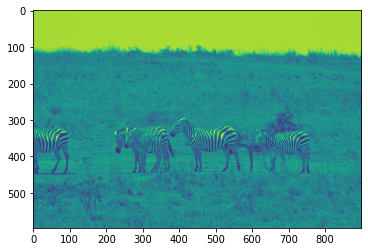

KeyboardInterrupt: ignored

In [ ]:
i = 4

sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()

plt.imshow(sample_x.numpy()[0])
plt.show()

plt.imshow(utils.create_img_bbox_mask(imgs[i], img_bboxes[i]))
plt.show()

resize_shape = (sample_x.shape[1], sample_x.shape[2])

noise_vol = 0.8
noise_scale_factor = 25
noise = get_noise((sample_x.shape[1], sample_x.shape[2]), noise_scale_factor)

avg_sal_map = np.mean(np.stack([
    get_saliency_map(model_32, 1, sample_x, gpu=USE_GPU, s=8),
    get_saliency_map(model_32, 2, sample_x, gpu=USE_GPU, s=6),
    get_saliency_map(model_32, 4, sample_x, gpu=USE_GPU, s=6),
    get_saliency_map(model_32, 1, sample_x, gpu=USE_GPU, s=8),
    get_saliency_map(model_64, 2, sample_x, gpu=USE_GPU, s=6),
    get_saliency_map(model_64, 4, sample_x, gpu=USE_GPU, s=6)
]), axis=0)

plt.imshow(avg_sal_map)
plt.show()

plt.imshow(cluster_img(avg_sal_map, 3, 1))
plt.show()

plt.imshow(create_img_bbox_mask(imgs[i], img_bboxes[i]) * avg_sal_map)
plt.show()

plt.imshow(create_img_bbox_mask(imgs[i], img_bboxes[i]) * cluster_img(avg_sal_map, 3, 1) * sample_x.numpy()[0] / 255.)
plt.show()

In [ ]:
i = 29
sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()
avg_sal_map = np.mean(np.stack([
    get_saliency_map(model_32, 3, sample_x, s=8)
]), axis=0)

plt.imshow(avg_sal_map)
plt.show()

NameError: ignored

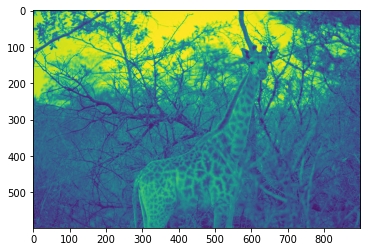

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


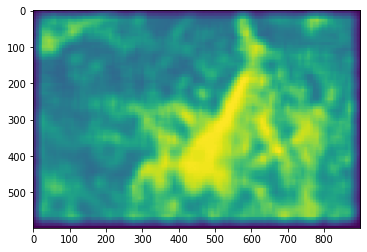

In [ ]:
i = 15
sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()
plt.imshow(sample_x[0])
plt.show()
pred_region = get_predicted_region(model_32, sample_x, patch_size=32, gpu=False)
plt.imshow(pred_region)
plt.show()

In [ ]:
# Save activation maps
SAVE_ACTIVATION_MAP_DIR = "data/outputs/activation_maps_v1/"

for i in range(MAX_IMGS):
    sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()
    avg_sal_map = np.mean(np.stack([
        get_saliency_map(model_32, 1, sample_x, gpu=USE_GPU, s=8),
        get_saliency_map(model_32, 2, sample_x, gpu=USE_GPU, s=6),
        get_saliency_map(model_32, 4, sample_x, gpu=USE_GPU, s=6),
        get_saliency_map(model_32, 1, sample_x, gpu=USE_GPU, s=8),
        get_saliency_map(model_64, 2, sample_x, gpu=USE_GPU, s=6),
        get_saliency_map(model_64, 4, sample_x, gpu=USE_GPU, s=6)
    ]), axis=0)

    cv2.imwrite(os.path.join(SAVE_ACTIVATION_MAP_DIR, "activation_maps", str(i) + ".png"), 255 * avg_sal_map)

In [ ]:
# Save activation maps
SAVE_ACTIVATION_MAP_DIR = "data/outputs/activation_maps_v2/"



In [ ]:
# Get predicted regions
sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()
pred_region = get_predicted_region(model_32, sample_x, patch_size=32, gpu=False)
print(i, MAX_IMGS)
pred_regions.append(pred_region)

In [ ]:

def save_activation_maps(act_maps, img_bboxes, save_activation_map_dir):
    pred_regions = []
    for i, act_map in enumerate(act_maps):
        cv2.imwrite(os.path.join(save_activation_map_dir, "activation_maps", str(i) + ".png"), 255. * np.float32(pred_region))

    # Save bounding boxes
    img_bboxes_json = dict({})
    for i, img_bbox in enumerate(img_bboxes):
        img_bboxes_json[i] = img_bbox

    with open(os.path.join(save_activation_map_dir, "img_bboxes.json"), 'w') as f:
        json.dump(img_bboxes_json, f)

In [ ]:
for i, img in enumerate(imgs):
    result = Image.fromarray(img.astype(np.uint8))
    result.save(os.path.join(SAVE_ACTIVATION_MAP_DIR, "images", str(i)) + ".png")

In [ ]:
i = 56

sample_x = torch.tensor(np.moveaxis(imgs[i], 2, 0)).float()

plt.imshow(sample_x.numpy()[0])
plt.show()

avg_sal_map = np.mean(np.stack([
    np.mean(model_16.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 2).detach().cpu().numpy()[0], axis=0),
    np.mean(model_32.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 2).detach().cpu().numpy()[0], axis=0),
    np.mean(up(model_32.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 3).detach().cpu()).numpy()[0], axis=0),
    np.mean(model_64.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 2).detach().cpu().numpy()[0], axis=0),
    np.mean(up(model_64.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 3).detach().cpu()).numpy()[0], axis=0),
    np.mean(model_128.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 2).detach().cpu().numpy()[0], axis=0),
    np.mean(up(model_128.saliency_map(torch.unsqueeze(sample_x, 0).cuda(), 3).detach().cpu()).numpy()[0], axis=0)
]), axis=0)
plt.imshow(avg_sal_map)
plt.show()
plt.imshow(cluster_img(avg_sal_map, 2, 1))
plt.show()
plt.imshow(cluster_img(avg_sal_map, 3, 1))
plt.show()
plt.imshow(cluster_img(avg_sal_map, 4, 1))
plt.show()
plt.imshow(cluster_img(avg_sal_map, 5, 1))
plt.show()